# plt_pie
- sns no tiene nada de pie no donuts charts
- Este es el último arch de pie

## TO-DO
- Add value_counts para casos donde que aggregate categories
- Nuevo etiquetado full_ext, para cuando los sectores sean muy chicos 
- ANALIZAR! el tema de poner o no títulos por default

In [1]:
## Standard Libs
from typing import Union, Optional, Tuple, Literal, Any
import warnings
import random

# Third-Party Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# # Local Libs
# from jm_datascience import jm_pandas as jm_pd
# from jm_datascience import jm_pdaccessor as jm
# from jm_utils import jm_richprt as jm_prt


## Some Series and DFs

In [2]:
df_work = pd.DataFrame({
    'nombre': ['Ana', 'Bob', '', 'Carlos', ' ', 'Diana'],
    'apellido': ['A_Ana', 'B_Bob', None, 'C_Carlos', None, 'D_Diana'],
    'edad': [25, -1, 30, 999, 28, 22],
    'ciudad': ['Madrid', 'N/A', 'Barcelona', 'Valencia', 'unknown', 'Sevilla'],
    'salario': [50000, 0, 60000, -999, 55000, 48000]
})

## Read spreedsheet for tests
try:
    spreedsheet = r"C:\Users\jm\Documents\__Dev\PortableGit\__localrepos\365DS_jm\3_statistics\2_13_Practical_Ex_Descriptive_Stats.xlsx"    # Casa
    with open(spreedsheet) as f:
        pass
except FileNotFoundError:
    spreedsheet = r"D:\git\PortableGit\__localrepos\365DS_jm\3_statistics\2_13_Practical_Ex_Descriptive_Stats.xlsx"                         # Office

df_xls = pd.read_excel(spreedsheet, skiprows=4, usecols='B:J,L:AA', index_col='ID')
df = df_xls.copy()

lst_str = random.choices([chr(i) for i in range(65, 72)], k=175)
# sr_str = jm_pd.to_series(lst_str)                         # <- jm_pd.to_serie_with_count()

In [3]:
def get_colorblind_palette_list():
    """
    Retorna una lista de colores (hexadecimales) amigables para personas
    con daltonismo, equivalentes a sns.color_palette('colorblind').
    """
    return [
        '#0173B2', '#DE8F05', '#029E73', '#D55E00', '#CC78BC',
        '#CA9161', '#FBAFE4', '#949494', '#ECE133', '#56B4E9',
        '#5D8C3B', '#A93967', '#888888', '#FFC107', '#7C9680',
        '#E377C2', '#BCBD22', '#AEC7E8', '#FFBB78', '#98DF8A',
        '#FF9896', '#C5B0D5', '#C49C94', '#F7B6D2', '#DBDB8D',
        '#9EDAE5', '#D68E3A', '#A65898', '#B2707D', '#8E6C87'
    ]


def get_colors_list(palette: str, n: Optional[int] = 10) -> list[str]:
    '''
    Return a valid matplotlib palette list
    - 'colorbind' <- daltonic, 'viridis', 'plasma', 'inferno', 'magma', 'cividis' <- daltonic, set3, set2
    - 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 
    'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 
    'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 
    'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 
    'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 
    'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 
    'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 
    'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r',
    'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 
    'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 
    'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 
    'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 
    'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r'",
    '''
    if n < 6:       # To get a softer range of colors if n is too small           
        n = 6

    if palette == 'colorblind':
        colors_list = get_colorblind_palette_list()
    elif palette == 'set2':
        colors_list = plt.cm.Set2(np.linspace(0, 1, n))
    elif palette == 'set3':
        colors_list = plt.cm.Set3(np.linspace(0, 1, n))
    else:
        cmap = plt.get_cmap(palette, n)              # Use palette colormap
        colors_list = [cmap(i) for i in range(n)]    # Get colors from the colormap

    return colors_list


In [4]:
def to_series(
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    index: Optional[pd.Index] = None,
    name: Optional[str] = None
) -> pd.Series:
    """
    Converts input data into a pandas Series, optionally returning value counts.

    This function accepts various data types and converts them into a pandas Series.
    If `count=True`, it returns the frequency count of the values in the resulting Series.

    Parameters:
        data (Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame]):
            The input data to convert. Supported types include:
            - pd.Series: returned as-is or counted if `count=True`.
            - np.ndarray: flattened and converted to a Series.
            - dict: keys become the index, values are used for data.
            - list or set: converted directly to a Series.
            - pd.DataFrame:
                - 1 column: converted directly to a Series.
                - 2 columns: first column becomes the index, second becomes the values.

        count (bool or int, optional): Whether to return value counts instead of raw data.
            If True or 1, returns frequencies of each value. Default is False.

    Returns:
        pd.Series: A pandas Series representing the input data. If `count=True`, returns
            the value counts of the data.

    Raises:
        TypeError: If `data` is not one of the supported types.
        ValueError: If `count` is not a boolean or integer 0/1.
        ValueError: If DataFrame has more than 2 columns.

    Examples:
        >>> import pandas as pd
        >>> to_serie_with_count([1, 2, 2, 3])
        0    1
        1    2
        2    2
        3    3
        dtype: int64

        >>> to_serie_with_count([1, 2, 2, 3], count=True)
        2    2
        1    1
        3    1
        dtype: int64

        >>> df = pd.DataFrame({'Category': ['A', 'B', 'A'], 'Value': [10, 20, 30]})
        >>> to_serie_with_count(df)
        Category
        A    10
        B    20
        A    30
        Name: Value, dtype: int64
    """
    
    # Validate parameters - FUTURE
    
    if isinstance(data, pd.Series):                 # If series is already a Series no conversion needed
        series = data                                  
    elif isinstance(data, np.ndarray):              # If data is a NumPy array   
        series = pd.Series(data.flatten())
    elif isinstance(data, (dict, list)):
        series = pd.Series(data)
    elif isinstance(data, (set)):
        series = pd.Series(tuple(data))
    elif isinstance(data, pd.DataFrame):
        if data.shape[1] == 1:                      # Also len(data.columns == 1)
            series = data.iloc[:, 0]
        elif data.shape[1] == 2:                    # Index: first col, Data: 2nd Col
            series = data.set_index(data.columns[0])[data.columns[1]]
        else:
            raise ValueError("DataFrame must have 1 oer 2 columns. Categories and values for 2 columns cases.")
    else:
        raise TypeError(f"Unsupported data type: {type(data)}. "
                    "Supported types: pd.Series, np.ndarray, pd.DataFrame, dict, list, set, and pd.DataFrame")

    if name:
        series.name = name

    if index:
        series.index = index

    return series

In [5]:
def _validate_numeric_series(
        data: Union[pd.Series, pd.DataFrame],
        positive: Optional[bool] = True
) -> Union[None, Exception]:

    # Validate data parameter a pandas object
    if not isinstance(data, (pd.Series, pd.DataFrame)):     # pd.Series or pd.Datafram
        raise TypeError(
            f"Input data must be a pandas Series or DataFrame. Got {type(data)} instead."
        )
              
    if positive:
        if not all(                                             # Only positve numeric values                 
            isinstance(val, (int, float, np.integer, np.floating)) and val > 0 for val in data.values
        ):
            raise ValueError(f"All values in 'data' must be positive numeric values.")
        pass
    else:                                                       # Just only numeric values
        if not all(isinstance(val, (int, float, np.integer, np.floating)) for val in data.values):
            raise ValueError(f"All values in 'data' must be numeric values.")
        pass

In [6]:
def plt_pie2(
    data: Union[pd.Series, pd.DataFrame],
    value_counts: Optional[bool] = False,
    nans: Optional[bool] = False,
    scale: Optional[int] = 2,
    figsize: Optional[tuple[float, float]] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    label_place: Optional[str] = 'ext',
    palette: Optional[list] = 'colorblind',
    startangle: Optional[float] = -40,
    pct_decimals: Optional[int] = 1,
    label_rotate: Optional[float] = 0,
    legend_loc: Optional[str] = 'best',
) -> tuple[plt.Figure, plt.Axes]:
    """
    Generates pie or donut charts for categorical data visualization with customizable labels.

    This function creates a pie or donut chart from categorical data using matplotlib.
    It supports internal or external labels, custom palettes, and formatting options.

    Parameters:
        data (pd.Series, pd.DataFrame, dict, or list): Input data. If a list is provided,
            frequencies are counted automatically.
        scale (int): Chart scaling factor (1 to 6). Default is 2.
        title (str or None): Optional title for the chart.
        kind (str): Type of chart: 'pie' or 'donut'. Default is 'pie'.
        label_place (str): Placement of labels: 'ext' (external) or 'int' (internal).
        palette (list of str or None): List of color hex codes for categories.
        startangle (float): Starting angle in degrees for the first wedge.
        pct_decimals (int): Number of decimal places for percentage labels. Default is 2.
        label_rotate (float): Rotation angle for internal labels. Default is 0.
        legend_loc (str): Position of the legend ('best', 'upper right', etc.). Default is 'best'.

    Returns:
        tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]: The Figure and Axes objects
            for further customization.

    Raises:
        ValueError: If data contains invalid values, if unsupported types are passed,
            if more than 9 categories are used, or if parameters like scale are out of range.
        TypeError: If data is not one of the accepted types.

    Examples:
        >>> import pandas as pd
        >>> data = pd.Series([25, 30, 20, 15, 10], index=['A', 'B', 'C', 'D', 'E'])
        >>> fig, ax = plt_pie(data, kind='donut', title='Donut Distribution')
        >>> plt.show()

        >>> data_list = ['A', 'B', 'A', 'C', 'B', 'B']
        >>> fig, ax = plt_pie(data_list, kind='pie', label_place='int')
        >>> plt.show()
    """
    # Convert to serie in case of ....
    sr = to_series(data)

    if value_counts:
        sr = sr.value_counts(sort=False, dropna=not nans)

    _validate_numeric_series(sr)

    # Validate kind parameter
    if kind.lower() not in ['pie', 'donut']:
        raise ValueError(f"Invalid 'kind' parameter: '{kind}'. Must be 'pie' or 'donut'.")
    
    # Validate maximum categories
    if len(sr) > 9:
        raise ValueError(f"Data contains {len(sr)} categories. "
                        "Maximum allowed is 9 categories.")
    
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 9:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '9', not '{scale}'.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = 1.33333334 ** scale
        w_base, h_base = 4.45, 2.25
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize
    
    # Calculate font sizes based on figure width
    label_size = width * 1.25
    title_size = width * 1.57

    # Base fig definitions
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    # Configure wedge properties for donut  or pie chart
    wedgeprops = {}
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.54, 'edgecolor': 'white', 'linewidth': 1}
    else:
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.5}

    # Define colors
    color_palette = get_colors_list(palette, len(data))

    if label_place == 'ext':

        wedges, texts = ax.pie(sr, wedgeprops=wedgeprops, colors=color_palette, startangle=startangle)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [
            f"{sr.loc[sr == value].index[0]}\n{value}\n({round(value / sr.sum() * 100, pct_decimals)} %)"
            for value in sr.values
        ]
        
        # Draw the annotations (labels)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, fontsize=label_size, **kw)
            
    elif label_place == 'int':
        label_size = label_size * 0.8
        legend_size = label_size * 1.1

        # autopct for internal annotations. A funtion to show both: absolute an pcts.
        format_string = f'%.{pct_decimals}f%%'

        def make_autopct(values, fmt_str):
            value_iterator = iter(values)
            
            def my_autopct(pct):
                absolute_value = next(value_iterator)
                percentage_string = fmt_str % pct
                return f"{absolute_value}\n({percentage_string})"  
            
            return my_autopct
        
        autopct_function = make_autopct(sr.values, format_string)
        
        ax.pie(x=sr,
            colors=color_palette,
            startangle=startangle,
            autopct=autopct_function,
            wedgeprops=wedgeprops,
            textprops={'size': label_size,
                        'color': 'w',
                        'rotation': label_rotate,
                        'weight': 'bold'})
        
        ax.legend(sr.index,
                loc=legend_loc,
                bbox_to_anchor=(1, 0, 0.2, 1),
                prop={'size': legend_size})

    else:
        raise ValueError(f"Invalid labe_place parameter. Must be 'ext' or 'int', not '{label_place}'.")
            
    # Build title
    if not title:
        title = f"Pie/Donut Chart - ({sr.name})"
    ax.set_title(title, fontdict={'size': title_size, 'weight': 'bold'})

    return fig, ax

In [7]:
df.columns
# sr_counted = df['Type of property'].value_counts()

Index(['Building', 'Year of sale', 'Month of sale', 'Type of property',
       'Property #', 'Area (ft.)', 'Price', 'Status', 'Customer ID', 'Entity',
       'Name', 'Surname', 'Age at time of purchase', 'Interval', 'Y', 'M', 'D',
       'Gender', 'Country', 'State', 'Purpose', 'Deal satisfaction',
       'Mortgage', 'Source'],
      dtype='object')

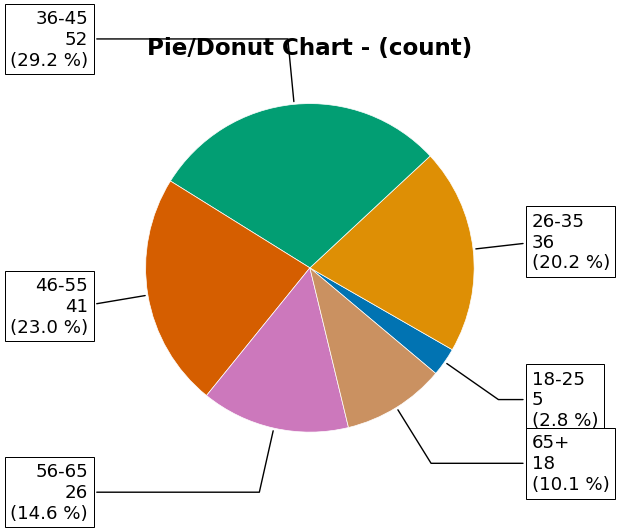

In [8]:
fig = plt_pie2(df['Interval'], value_counts=True, scale=3, label_place='ext')
# fig = plt_pie2(df['Interval'], value_counts=True, scale=3, nans=True, label_place='ext')
# fig = plt_pie2(sr_counted, scale=3, label_place='ext')

In [9]:
sr = to_series(df['Gender'])
sr = sr.value_counts(sort=False, dropna=True)
sr.values.sum()
sr.sum()

np.int64(178)

In [28]:
## out labels
def plt_pie3(
    data: Union[pd.Series, pd.DataFrame],
    value_counts: Optional[bool] = False,
    sort: Optional[bool] = False,
    nans: Optional[bool] = False,
    scale: Optional[int] = 1,
    figsize: Optional[tuple[float, float]] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    label_place: Optional[str] = 'ext',
    palette: Optional[list] = 'colorblind',
    startangle: Optional[float] = -40,
    pct_decimals: Optional[int] = 1,
    label_rotate: Optional[float] = 0,
    legend_loc: Optional[str] = 'best',
) -> tuple[plt.Figure, plt.Axes]:
    """
    Generates pie or donut charts for categorical data visualization with customizable labels.

    This function creates a pie or donut chart from categorical data using matplotlib.
    It supports internal or external labels, custom palettes, and formatting options.

    Parameters:
        data (pd.Series, pd.DataFrame, dict, or list): Input data. If a list is provided,
            frequencies are counted automatically.
        scale (int): Chart scaling factor (1 to 6). Default is 2.
        title (str or None): Optional title for the chart.
        kind (str): Type of chart: 'pie' or 'donut'. Default is 'pie'.
        label_place (str): Placement of labels: 'ext' (external) or 'int' (internal).
        palette (list of str or None): List of color hex codes for categories.
        startangle (float): Starting angle in degrees for the first wedge.
        pct_decimals (int): Number of decimal places for percentage labels. Default is 2.
        label_rotate (float): Rotation angle for internal labels. Default is 0.
        legend_loc (str): Position of the legend ('best', 'upper right', etc.). Default is 'best'.

    Returns:
        tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]: The Figure and Axes objects
            for further customization.

    Raises:
        ValueError: If data contains invalid values, if unsupported types are passed,
            if more than 9 categories are used, or if parameters like scale are out of range.
        TypeError: If data is not one of the accepted types.

    Examples:
        >>> import pandas as pd
        >>> data = pd.Series([25, 30, 20, 15, 10], index=['A', 'B', 'C', 'D', 'E'])
        >>> fig, ax = plt_pie(data, kind='donut', title='Donut Distribution')
        >>> plt.show()

        >>> data_list = ['A', 'B', 'A', 'C', 'B', 'B']
        >>> fig, ax = plt_pie(data_list, kind='pie', label_place='int')
        >>> plt.show()
    """
    # Convert to serie in case of ....
    sr = to_series(data)

    if value_counts:
        sr = sr.value_counts(sort=sort, dropna=not nans)

    _validate_numeric_series(sr)

    # Validate kind parameter
    if kind.lower() not in ['pie', 'donut']:
        raise ValueError(f"Invalid 'kind' parameter: '{kind}'. Must be 'pie' or 'donut'.")
    
    # Validate maximum categories
    if len(sr) > 12:
        raise ValueError(f"Data contains {len(sr)} categories. "
                        "Maximum allowed is 12 categories.")
    
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 9:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '9', not '{scale}'.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = scale + 7.5
        w_base, h_base = 1, 0.56
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize
    
    # Calculate font sizes based on figure width
    label_size = width * 1.25
    title_size = width * 1.57

    # Base fig definitions
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    # Configure wedge properties for donut  or pie chart
    wedgeprops = {}
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.54, 'edgecolor': 'white', 'linewidth': 1}
    else:
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.5}

    # Define colors
    color_palette = get_colors_list(palette, len(sr))

    if label_place == 'ext':

        wedges, texts = ax.pie(sr, wedgeprops=wedgeprops, colors=color_palette, startangle=startangle)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [
            f"{sr.loc[sr == value].index[0]}\n{value}\n({round(value / sr.sum() * 100, pct_decimals)} %)"
            for value in sr.values
        ]
        
        # Draw the annotations (labels)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, fontsize=label_size, **kw)
            
    elif label_place == 'int' or label_place == 'aside':
        label_size = label_size * 0.8
        legend_size = label_size * 1.1
        
        # Set autopct and legends, different for 'int' and 'aside' label_place
        if label_place == 'int':
            # autopct for internal annotations. A funtion to show both: absolute an pcts.
            format_string = f'%.{pct_decimals}f%%'

            def _make_autopct(values, fmt_str):     # A python Closuer
                value_iterator = iter(values)
                
                def my_autopct(pct):
                    absolute_value = next(value_iterator)
                    percentage_string = fmt_str % pct
                    return f"{absolute_value}\n({percentage_string})"  
                
                return my_autopct
            
            autopct_function = _make_autopct(sr.values, format_string)

            legends = sr.index

        else:
            # Valid autopct and legends in case of 'aside' label_place
            autopct_function = None         # No data inside de pie or donut
            #   - Custom legends w/labels values and pct aside of the pie
            total = sr.values.sum()         
            legends = [f"{sr.index[i]} \n| {value} | {round(value / total * 100, pct_decimals)} %"
                    for i, value in enumerate(sr.values)] 

        ax.pie(x=sr,
            colors=color_palette,
            startangle=startangle,
            autopct=autopct_function,
            wedgeprops=wedgeprops,
            textprops={'size': label_size,
                        'color': 'w',
                        'rotation': label_rotate,
                        'weight': 'bold'})
        
        ax.legend(legends,
                loc=legend_loc,
                bbox_to_anchor=(1, 0, 0.2, 1),
                prop={'size': legend_size})

    else:
        raise ValueError(f"Invalid labe_place parameter. Must be 'ext' or 'int', not '{label_place}'.")
            
    # Build title
    if not title:
        title = f"Pie/Donut Chart - ({sr.name})"
    ax.set_title(title, fontdict={'size': title_size, 'weight': 'bold'})

    return fig, ax

In [29]:
df.columns

Index(['Building', 'Year of sale', 'Month of sale', 'Type of property',
       'Property #', 'Area (ft.)', 'Price', 'Status', 'Customer ID', 'Entity',
       'Name', 'Surname', 'Age at time of purchase', 'Interval', 'Y', 'M', 'D',
       'Gender', 'Country', 'State', 'Purpose', 'Deal satisfaction',
       'Mortgage', 'Source'],
      dtype='object')

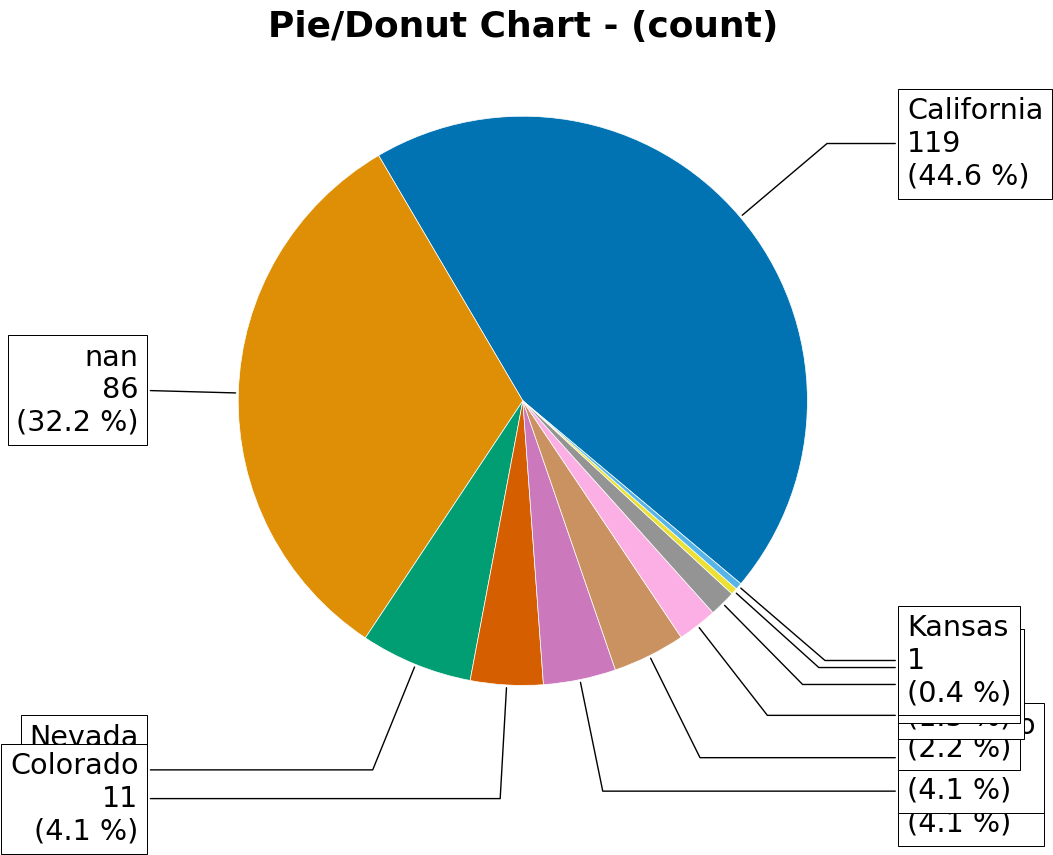

In [35]:
fig = plt_pie3(df['State'], value_counts=True, label_place='ext', nans=True, sort=True, scale=9)

In [13]:
# def get_fdt(
#         data: Union[pd.Series, np.ndarray, dict, list, pd.DataFrame],
#         value_counts: Optional[bool] = False,
#         pcts: Optional[bool] = True,
#         plain_relatives: Optional[bool] = True,
#         fmt_values: Optional[bool] = False,
#         sort: Optional[str] = 'desc',
#         nans: Optional[str] = 'drop'
# ) -> pd.DataFrame:
#     '''
#     Generata a Frequency Distribution Table (fdt)

#     data: puede ser ya con el value_counts() hecho o no
#     sort: 'desc', 'asc', 'ix_asc', 'ix_desc', para como queremos que sea vea el orden por valores o por indice
#     nans: 'drop', 'last', 'sort'
#     '''
#     columns = [
#         'Frequency',
#         'Cumulative Frequency',
#         'Relative Frequency',
#         'Cumulative Relative Freq.',
#         'Relative Freq. [%]',
#         'Cumulative Freq. [%]'
#     ]
    
#     sr = to_series(data)
#     # nans = sr.isna().sum()        # FUTURE to think if nans is interesting to see here or in a pareto u other categorical chart

#     if value_counts:
#         sr = sr.value_counts()

#     fdt = pd.DataFrame(sr)
#     fdt.columns = [columns[0]]
#     fdt[columns[1]] = fdt['Frequency'].cumsum()
#     fdt[columns[2]] = fdt['Frequency'] / fdt['Frequency'].sum()
#     fdt[columns[3]] = fdt['Relative Frequency'].cumsum()
#     fdt[columns[4]] = fdt['Relative Frequency'] * 100
#     fdt[columns[5]] = fdt['Cumulative Relative Freq.'] * 100

#     if not pcts:                    # Don't return percentage columns
#         fdt = fdt[columns[0:4]]
    
#     if not plain_relatives:         # Don't return relative and plain cumulative
#         fdt = fdt[[columns[0], columns[4], columns[5]]]

#     # if fmt_values:
#     #     fdt = fdt.map(_fmt_value_for_pd)
        
#     match sort:
#         case 'asc':
#             return fdt.sort_values(by=columns[0])
#         case 'ix_asc':
#             return fdt.sort_index()
#         case 'ix_desc':
#             return fdt.sort_index(ascending=False)
#         case _:
#             return fdt